In [1]:
import pandas as pd
import json
import re

In [2]:
# lets transform the data into a pandas dataframe, currently it is stored in a dictionary of k=str, v=list[str]
# we will use the json module to load the data from the json file
with open('../Data/data_chan.json', 'r') as f:
    data = json.load(f)

# Create a pandas dataframe with 2 title and comment columns
df = pd.DataFrame(columns=['title', 'comment'])

# Iterate through the dictionary and append the data to the dataframe
for title, comments in data.items():
    for comment in comments:
        df = df.append({'title': title, 'comment': comment}, ignore_index=True)

/tmp/ipykernel_22658/1957978118.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'title': title, 'comment': comment}, ignore_index=True)
/tmp/ipykernel_22658/1957978118.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'title': title, 'comment': comment}, ignore_index=True)
/tmp/ipykernel_22658/1957978118.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'title': title, 'comment': comment}, ignore_index=True)
/tmp/ipykernel_22658/1957978118.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'title': title, 'comment': comment}, ignore_index=True)
/tmp/ipykernel_2

In [3]:
df.head()

,title,comment
0,All the cool kids are doing it.,&gt;&gt;400714173&gt;no pepe what are you doin...
1,All the cool kids are doing it.,&gt;&gt;400708757https://www.youtube.com/watch...
2,All the cool kids are doing it.,&gt;&gt;400713918&gt;if you don&#039;t like th...
3,All the cool kids are doing it.,&gt;&gt;400708823And I wonder how many big ole...
4,All the cool kids are doing it.,&gt;&gt;400714594Vatniggers get into the meat ...


In [4]:
# lets make some preeliminary analysis on the data with spacy
import spacy
nlp = spacy.load('en_core_web_md')

In [5]:
# clean the text from 'title' and 'comment' columns
def clean_text(text):
    # make everything lowercase
    text = text.lower()
    # only lowercase letters no numbers or special characters
    text = re.sub(r'[^a-z]', ' ', text)
    
    # only accept nouns, pronouns and entities
    doc = nlp(text)
    text = [token.text for token in doc if token.pos_ in ['NOUN', 'PROPN', 'PRON', 'ADJ'] and len(token.text) > 3 and 'quot' not in token.text]
    return text

In [6]:
# apply the clean_text function to the dataframe
# df['title'] = df['title'].apply(clean_text)
df['comment'] = df['comment'].apply(clean_text)

In [7]:
df.head()

,title,comment
0,All the cool kids are doing it.,"[pepe, what, body]"
1,All the cool kids are doing it.,"[https, youtube, watch, svsoh]"
2,All the cool kids are doing it.,"[richard, spencer, tier, opposition, ukrainian..."
3,All the cool kids are doing it.,"[many, brains, titanic, imagery, their, meme, ..."
4,All the cool kids are doing it.,"[vatniggers, meat, grinder]"


In [8]:
# lets create a new column with the length of the comment
df['length'] = df['comment'].apply(lambda x: len(x))

In [9]:
# lets analyze the sentiment of the comments
from spacytextblob.spacytextblob import SpacyTextBlob
nlp.add_pipe('spacytextblob')

In [10]:
# lets create a new column with the sentiment of the comment
df['sentiment'] = df['comment'].apply(lambda x: nlp(' '.join(x))._.blob.polarity)

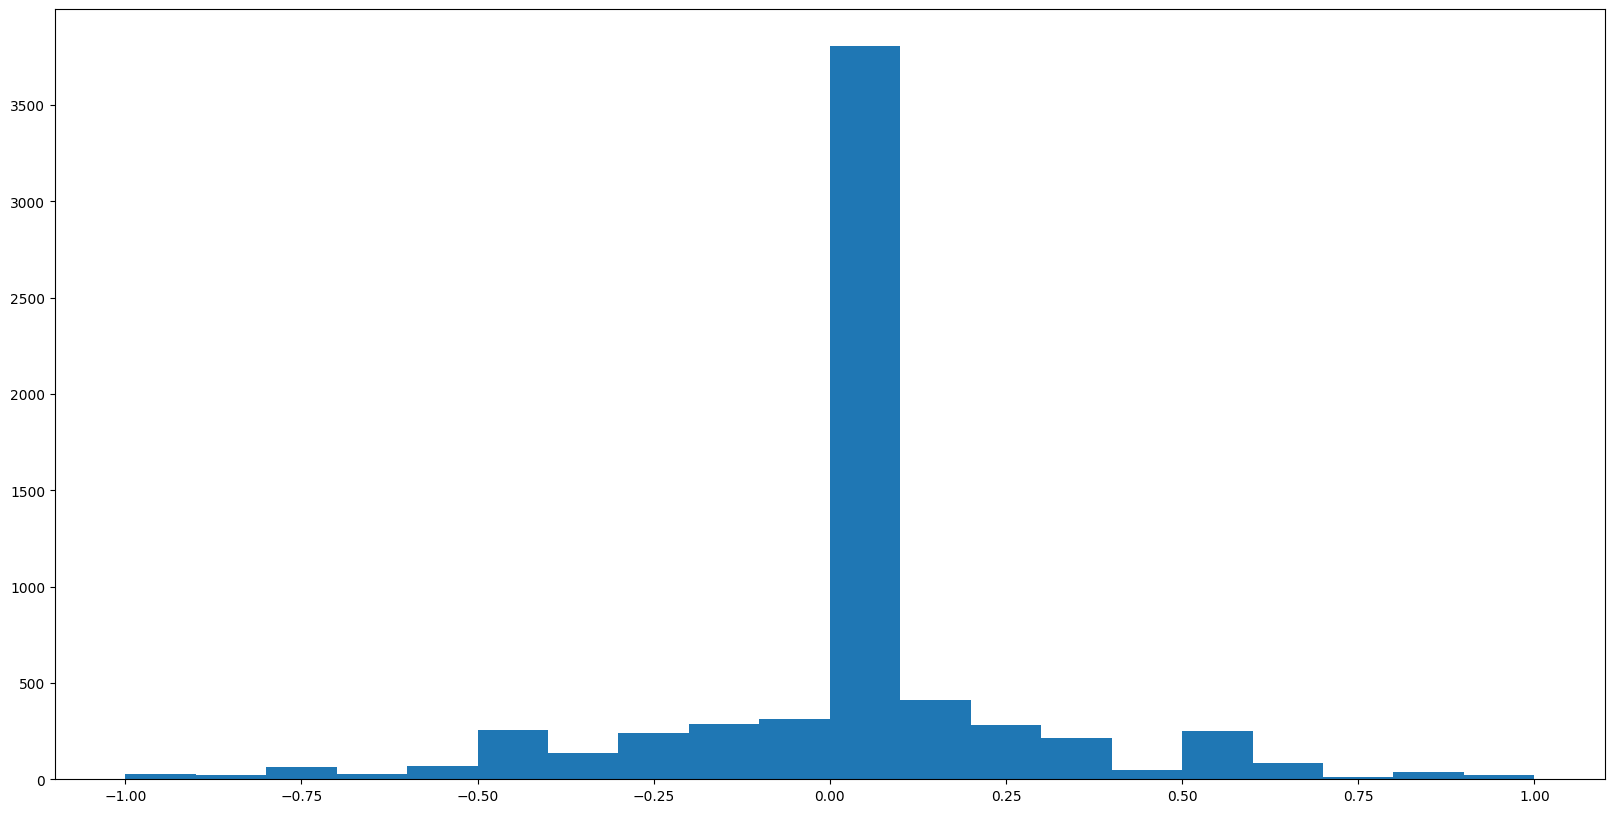

In [11]:
# lets plot the sentiment of the comments
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.hist(df['sentiment'], bins=20)
plt.show()

In [12]:
# show 5 samples of negative comments, in which sentiment is less than -0.5
df[df['sentiment'] < -0.5].sample(5)

,title,comment,length,sentiment
2810,He openly supports genocide of palestinians. I...,"[boring, them]",2,-1.0
2504,PRESIDENT DONALD J TRUMP @POTUS45https://www.d...,"[akari, destroyedcheck, fucking, askuka, frens...",7,-0.7
1382,This shithole of a country gets what it deserv...,"[brexit, they, butthurtyou, patheticnow, fucki...",8,-0.6
3682,"&gt;You weep for Trump&#039;s twitter account,...","[fucking, indians, president, america, country...",6,-0.6
5691,I see /pol/ putting emphasis on physical stren...,"[hate, that]",2,-0.8


In [13]:
# show 5 samples of positive comments, in which sentiment is greater than 0.5
df[df['sentiment'] > 0.5].sample(5)

,title,comment,length,sentiment
1408,"&gt;&quot;Ross Mtangi, a trading executive at ...","[mommy, therapist, best, sure]",4,0.75
5414,Powerful,[lmao],1,0.60
2128,ASIANS &gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt...,"[alternative, hypothesis, good]",3,0.70
6544,HOW IS THIS POSSIBLE?,[lmao],1,0.60
1453,"Apparently, the UK is offering subsidies for a...","[trick, more, refugees, people, nice, housing,...",8,0.55


In [14]:
# lets create a new column with the subjectivity of the comment
df['subjectivity'] = df['comment'].apply(lambda x: nlp(' '.join(x))._.blob.subjectivity)

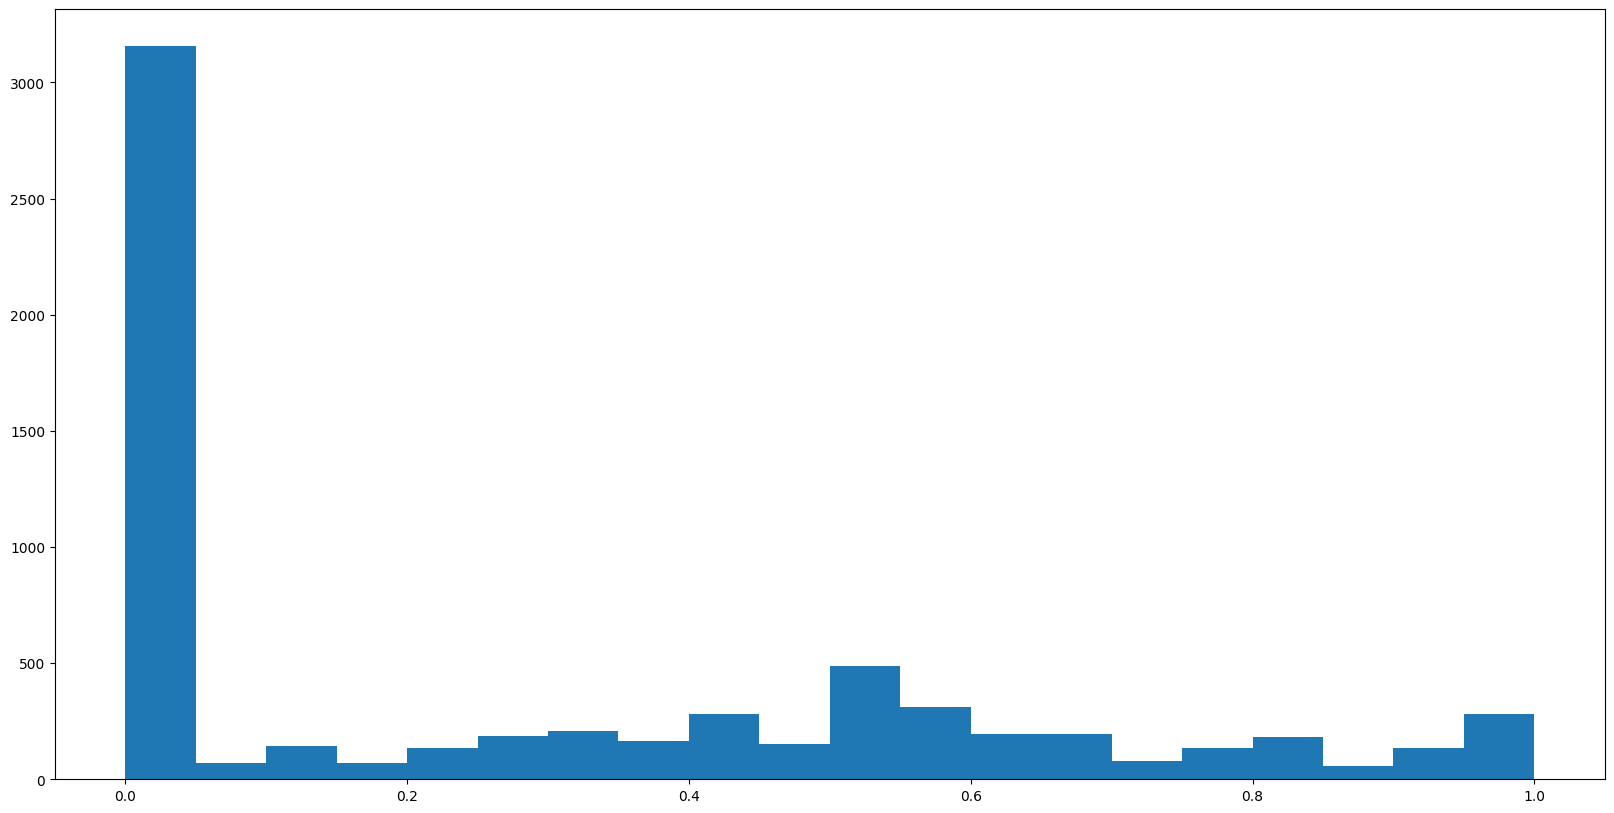

In [15]:
# lets plot the subjectivity of the comments
plt.figure(figsize=(20, 10))
plt.hist(df['subjectivity'], bins=20)
plt.show()

In [16]:
# show 5 samples of subjective comments, in which subjectivity is greater than 0.5
df[df['subjectivity'] > 0.5].sample(5)

,title,comment,length,sentiment,subjectivity
1722,"Don&#039;t fall for it, /pol/. Don&#039;t you ...","[this, years, favorite, insane, scene, second]",6,-0.166667,0.666667
5729,Why are they pushing wine so much?,"[wine, beer, americas, favorite, drink, they, ...",9,0.500000,1.000000
3554,polcels btfo,"[naked, that, extreme, attention]",4,-0.062500,0.700000
2653,What exactly am I in for?,"[correct, splinter, faction, same, knowledge, ...",20,-0.066667,0.508333
6082,The Delphi Murders Press Conference starts in ...,"[they, their, different, sketches, sense, dude...",7,0.000000,0.600000


In [17]:
# show 5 samples of objective comments, in which subjectivity is less than 0.5
df[df['subjectivity'] < 0.5].sample(5)

,title,comment,length,sentiment,subjectivity
1211,UKRAINE TO DETONATE LOW YIELD NUKE IN FALSE FL...,"[americans, possession, russian, nukes, capabl...",11,-0.050,0.250000
5171,&gt;Elon and 200 other elites are meeting in D...,"[timid, chick, first, chirp, emboldened, line,...",15,0.475,0.466667
1158,Nukes are flying after an escalation in Ukrain...,"[indoor, plants, their, soil, scavenge, greenh...",17,0.100,0.400000
137,Will you be voooting for the anti groomer cand...,"[what, fags, much, they, screamnobody, them, a...",11,0.200,0.200000
6442,&gt;Jamin Ben Raskin[2] was born to a Jewish f...,"[your, bankers, churches, that]",4,0.000,0.000000


12359


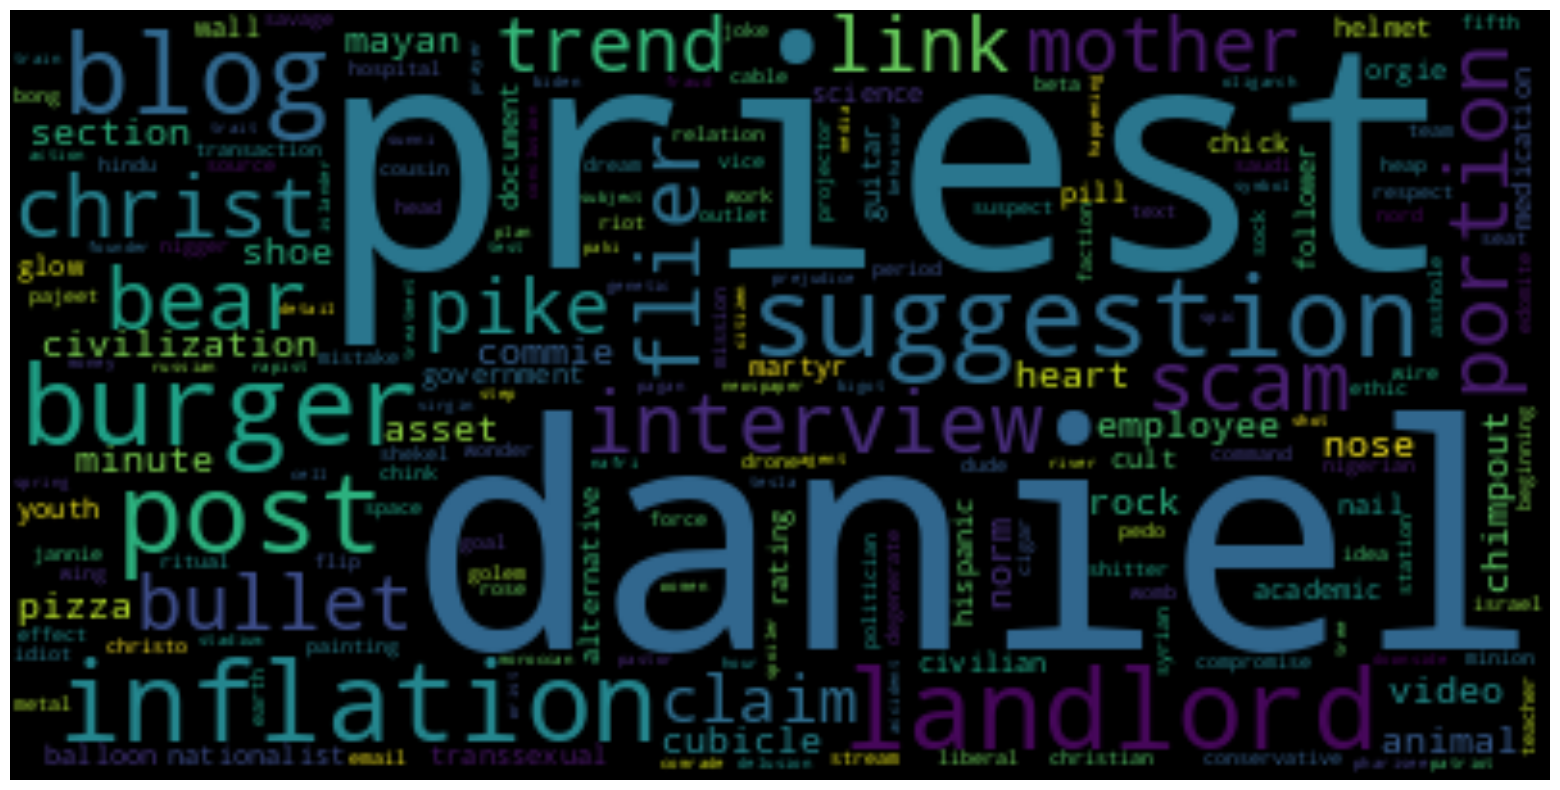

In [18]:
# lets create a word cloud of the most common words in the comments
from wordcloud import WordCloud

# create a string of all the comments
all_comments = set()
for comment in df['comment']:
    all_comments.update(comment)

print(len(all_comments)) # the number of unique words in the comments

# create a word cloud object
wordcloud = WordCloud().generate(' '.join(all_comments))

# plot the word cloud, make it larger
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

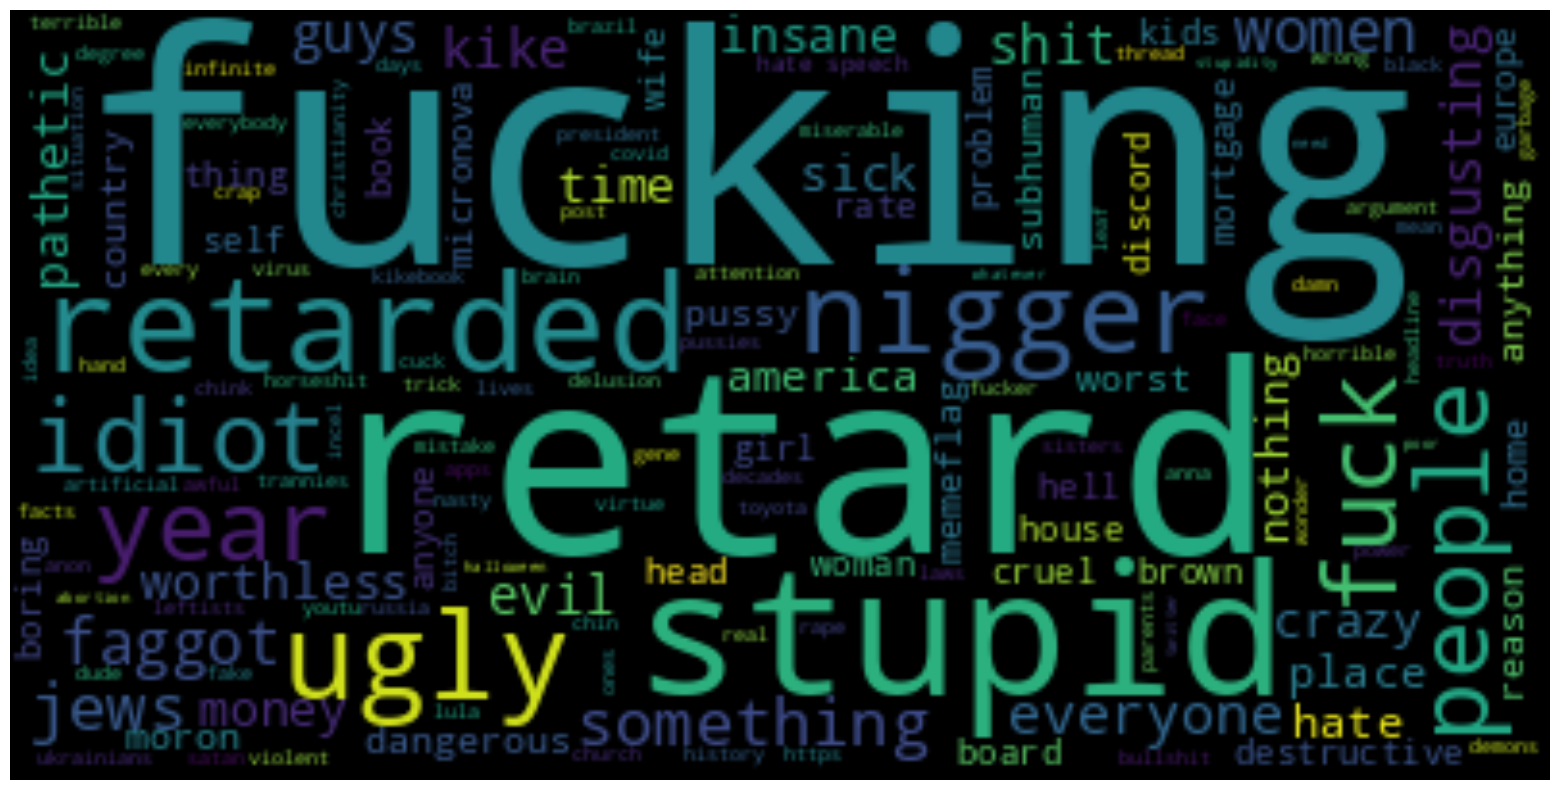

In [19]:
# lets create a word cloud of the most common words in the comments, but only for negative comments
negative_comments = ' '.join(df[df['sentiment'] < -0.5]['comment'].apply(lambda x: ' '.join(x)))

# create a word cloud object
wordcloud = WordCloud().generate(negative_comments)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [20]:
# check how many unique words are in the comments
total_unique = len(all_comments)

total_words = 0
for comment in df['comment']:
    total_words += len(comment)

# average unique words per comment
unique_words_by_comment = total_unique / total_words
unique_words_by_comment

0.22686638397855977

In [21]:
total_words

54477

In [22]:
# check how many average words are in the comments
average_words_by_comment = sum(df['length']) / len(df)
average_words_by_comment

8.231640979147778

In [23]:
# load the 2 other data frames to check on hate speech
df_hate = pd.read_csv('../../GeneralData/ethnic_slurs.csv')
df_hate.head(20)

,Term,Location,Target,Meaning
0,abbie abe abie,north america,jewish men,originated before the 1950s from the proper na...
1,abc,east asia,americanborn chinese han or other chinese incl...,the term implies an otherness or lack of conne...
2,abcd,south asians in the us,americanborn confused desi indian americans or...,used chiefly by south asian immigrants to impl...
3,abidabeed plural,middle east and north africa,black african people,arabic for slave associated with the arab slav...
4,aboabbo,australia,australian aboriginal person,originally this was simply an informal term fo...
5,afro engineering african engineering or nigger...,united states,black american people,shoddy secondrate or unconventional makeshift ...
6,ah chah,hong kong,south asian people,from cantonese yale ach from acch meaning good...
7,ali baba,united states,iraqi people,an iraqi suspected of criminal activity
8,alligator bait gator bait,united states more commonly used in states whe...,black people especially black children,first used in the early 20th century although ...
9,alpine serb,serbocroatian alpski srbin exyugoslavia,people of slovenian origin,


In [24]:
# r strip Location column
df_hate['Location'] = df_hate['Location'].apply(lambda x: x.rstrip())
df_hate.head(20)

,Term,Location,Target,Meaning
0,abbie abe abie,north america,jewish men,originated before the 1950s from the proper na...
1,abc,east asia,americanborn chinese han or other chinese incl...,the term implies an otherness or lack of conne...
2,abcd,south asians in the us,americanborn confused desi indian americans or...,used chiefly by south asian immigrants to impl...
3,abidabeed plural,middle east and north africa,black african people,arabic for slave associated with the arab slav...
4,aboabbo,australia,australian aboriginal person,originally this was simply an informal term fo...
5,afro engineering african engineering or nigger...,united states,black american people,shoddy secondrate or unconventional makeshift ...
6,ah chah,hong kong,south asian people,from cantonese yale ach from acch meaning good...
7,ali baba,united states,iraqi people,an iraqi suspected of criminal activity
8,alligator bait gator bait,united states more commonly used in states whe...,black people especially black children,first used in the early 20th century although ...
9,alpine serb,serbocroatian alpski srbin exyugoslavia,people of slovenian origin,


In [25]:
# make a set of all unique words in Term 
hate_terms = set()
for term in df_hate['Term']:
    for word in term.split():
        if len(word) < 4:
            continue
        hate_terms.add(word)

In [26]:
# check if the comments contain any of the hate words
hate_score = []
for comment in df['comment']:
    hate_count = 0
    for content in comment:
        for word in hate_terms:
            if word in content:
                hate_count += 1

    hate_score.append(hate_count)

# add the hate score to the dataframe
df['hate_score'] = hate_score
df.head()
                

,title,comment,length,sentiment,subjectivity,hate_score
0,All the cool kids are doing it.,"[pepe, what, body]",3,0.00,0.00,0
1,All the cool kids are doing it.,"[https, youtube, watch, svsoh]",4,0.00,0.00,0
2,All the cool kids are doing it.,"[richard, spencer, tier, opposition, ukrainian...",8,0.20,0.30,1
3,All the cool kids are doing it.,"[many, brains, titanic, imagery, their, meme, ...",9,0.15,0.65,0
4,All the cool kids are doing it.,"[vatniggers, meat, grinder]",3,0.00,0.00,1


In [27]:
df.head(20)

,title,comment,length,sentiment,subjectivity,hate_score
0,All the cool kids are doing it.,"[pepe, what, body]",3,0.000000,0.000000,0
1,All the cool kids are doing it.,"[https, youtube, watch, svsoh]",4,0.000000,0.000000,0
2,All the cool kids are doing it.,"[richard, spencer, tier, opposition, ukrainian...",8,0.200000,0.300000,1
3,All the cool kids are doing it.,"[many, brains, titanic, imagery, their, meme, ...",9,0.150000,0.650000,0
4,All the cool kids are doing it.,"[vatniggers, meat, grinder]",3,0.000000,0.000000,1
5,&gt;Two 16-year-old twins escaped from their a...,"[something, some]",2,0.000000,0.000000,0
6,&gt;Two 16-year-old twins escaped from their a...,[test],1,0.000000,0.000000,0
7,&gt;Two 16-year-old twins escaped from their a...,"[they, black, nobody, this]",4,-0.166667,0.433333,1
8,&gt;Two 16-year-old twins escaped from their a...,"[true, bolivian]",2,0.350000,0.650000,0
9,&gt;Two 16-year-old twins escaped from their a...,"[bitch, your, good, women, physical, mental, h...",7,0.200000,0.314286,0


In [28]:
# get the top 5 rows with the highest hate score
df.sort_values(by='hate_score', ascending=False).head(5)

,title,comment,length,sentiment,subjectivity,hate_score
4981,He is mostly known for not being Michael Jorda...,"[nigger, nigger, nigger, nigger, nigger, nigge...",113,0.000000,0.000000,113
5092,your corrupt right wing politicians are crumbl...,"[this, spam, thread, faggot, niggers, obvious,...",88,0.000000,0.500000,22
3768,What do I put on it /pol/?,"[nigger, niggerniggerniggernigger, niggernigge...",16,0.000000,0.000000,16
3119,Even Reddit of all places is not buying it any...,"[they, they, disproportional, amount, whites, ...",98,0.010667,0.342667,14
6098,How to fix the former Yugoslavia. Give all the...,"[kosovan, serbi, they, biggest, cultural, impa...",116,0.032917,0.337917,12


In [29]:
# Get the percentage of hate score devided by the total length of the comment
df['hate_score_percentage'] = df['hate_score'] / df['length'] * 100
df.head()

,title,comment,length,sentiment,subjectivity,hate_score,hate_score_percentage
0,All the cool kids are doing it.,"[pepe, what, body]",3,0.00,0.00,0,0.000000
1,All the cool kids are doing it.,"[https, youtube, watch, svsoh]",4,0.00,0.00,0,0.000000
2,All the cool kids are doing it.,"[richard, spencer, tier, opposition, ukrainian...",8,0.20,0.30,1,12.500000
3,All the cool kids are doing it.,"[many, brains, titanic, imagery, their, meme, ...",9,0.15,0.65,0,0.000000
4,All the cool kids are doing it.,"[vatniggers, meat, grinder]",3,0.00,0.00,1,33.333333


In [30]:
# get the sum of the total hate score / sum of the total length of the comment * 100
percentage_total_hate = df['hate_score'].sum() / df['length'].sum() * 100
f"{percentage_total_hate:.2f}%"

'6.02%'